In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
train_dir = '/opt/dkube/input/severstal-steel-defect-detection/' 
val_size = .20
train_image_dir = os.path.join(train_dir, 'train_images')
batch_size = 25

In [3]:
def rle_to_mask(rle_string,height,width):
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def mask_to_rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [48]:
def get_mask(image_dir, row, img_w, img_h):
    img_id = row['ImageId']
#     print(img_id)
    file_path =  os.path.join(image_dir, img_id)
#     print(file_path)
    image = cv2.imread(file_path, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # standardization of the image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()

    mask = np.empty((img_h, img_w, 4))

    rle = row['EncodedPixels']
    for idm, image_class in enumerate([1,2,3,4]):
        rle = row['EncodedPixels']
        if row['ClassId'] == image_class:
            class_mask = rle_to_mask(rle, width=1600, height=256)
        else:
            class_mask = np.zeros((1600, 256))

        class_mask_resized = cv2.resize(class_mask, (img_w,img_h))
        mask[...,idm] = class_mask_resized
    X = np.expand_dims(image_resized, axis=2)
    y = mask
        
        # normalize Y
    y = (y > 0).astype(np.float32)

    return X, y

In [49]:
img_w = 1600 # resized weidth
img_h = 256 # resized height
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv')).fillna(-1)

In [50]:
train_df.iloc[0]['ImageId']

'0002cc93b.jpg'

In [56]:
X, y = get_mask(train_image_dir, train_df.iloc[100], img_w, img_h)

In [52]:
print(X.shape, y.shape)

(256, 1600, 1) (256, 1600, 4)


## Input Image

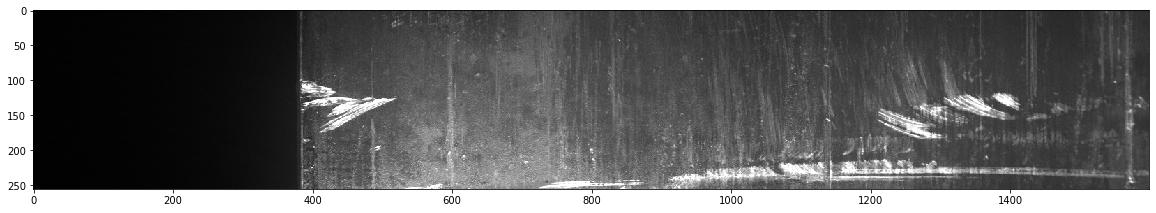

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20,80))
plt.imshow(X.reshape(256,1600), cmap='gray')

## Output Mask

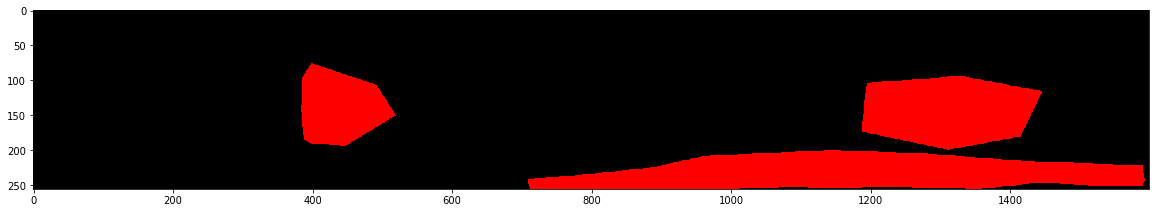

In [58]:
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
from matplotlib import pyplot as plt
plt.figure(figsize = (20,80))
plt.imshow(y)